In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle

%matplotlib inline

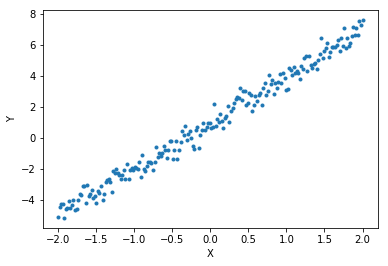

In [2]:
N = 200  # size of toy data

def build_linear_dataset(N, noise_std=0.5):
    X = np.linspace(-2, 2, num=N)
    Y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, Y = X.reshape((N, 1)), Y.reshape((N, 1))
    return X, Y

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

X, Y = build_linear_dataset(N)

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [3]:
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)

def mdn_loss_function(out_alpha, out_sigma, out_mu, y):
    result = (gauss_pdf(y, out_mu, Variable(torch.ones((1)))) * out_alpha).squeeze()
    result = torch.log(result)
    result = torch.mean(result)  # mean over samples and batch
    return -result

def mdn_kl_term(mps, sps, wdecay):
    assert wdecay > 0.0
    n_params = sum([mp.nelement() for mp in mps])
    L1 = 0.5 * wdecay * (sum([torch.sum(mp**2) for mp in mps]) +
                         sum([torch.sum(torch.exp(sp * 2)) for sp in sps]))
    L2 = sum([torch.sum(sp) for sp in sps])
    Lc = 0.5 * n_params * (1.0 + np.log(wdecay))
    L = L1 - L2 - Lc
    return L

In [ ]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_samples=9, 
                 sigma_prior=0.1, svi=True, activation=nn.Tanh()):
        super(FullyConnectedLayer, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_samples = n_samples
        self.sigma_prior = sigma_prior
        self.svi = svi
        self.activation = activation
        
        self.W_mu = nn.Parameter(torch.Tensor(n_inputs, n_outputs).normal_(0, 1/np.sqrt(n_inputs)))
        self.b_mu = nn.Parameter(torch.Tensor(n_outputs).uniform_(-0.01, 0.01))
        
        if self.svi:
            self.W_logsigma = nn.Parameter(torch.Tensor(n_inputs, n_outputs).uniform_(-4., -6.))
            self.b_logsigma = nn.Parameter(torch.Tensor(n_outputs).uniform_(-4., -6.))

    def forward(self, X, sample=True, debug=False):
        """
        In  : (n_batch, n_input) or (n_samples, n_batch, n_input)
        Out : (n_samples, n_batch, n_outputs)
        """
        if sample:
            X = X[None, :, :] if X.dim() == 2 else X
        if debug: print('In  : {}'.format(X.size()))

        # mean activation
        ma = torch.matmul(X, self.W_mu) + self.b_mu
        
        # stochastic activation
        if self.svi and sample:
            sa = torch.matmul(X**2, torch.exp(2*self.W_logsigma)) + torch.exp(2*self.b_logsigma)
            ua = Variable(torch.Tensor(self.n_samples, 1, self.n_outputs).normal_())
            output = torch.sqrt(sa)*ua + ma
        else:
            output = ma
        if debug: print('Out : {}'.format(output.size()))

        if self.activation is not None:
            return self.activation(output)
        else:
            return output

In [4]:
class MDN(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hiddens=[5], n_components=1, 
                 n_samples=1, svi=True):
        super(MDN, self).__init__()
        self.n_components = n_components
        self.n_samples = n_samples
        self.svi = svi
        
        # convert n_hiddens if needed
        if type(n_hiddens) == list:
            self.n_hiddens = n_hiddens
        elif type(n_hiddens) == int:
            self.n_hiddens = [n_hiddens]
        else:
            raise ValueError
            
        # shared keyword arguments
        skwargs = {'n_samples': n_samples, 'svi': svi}

        n_ci = ndim_input
        self.layers = {}
        for idx, n_hidden in enumerate(self.n_hiddens):
            self.layers['fc_{}'.format(idx+1)] = FullyConnectedLayer(n_ci, n_hidden, **skwargs)
            n_ci = n_hidden
        
        self.alpha_out = FullyConnectedLayer(n_ci, n_components, activation=None, **skwargs)
        self.logsigma_out = FullyConnectedLayer(n_ci, n_components, activation=None, **skwargs)
        self.mu_out = FullyConnectedLayer(n_ci, n_components, activation=None, **skwargs)
        
        # activation for alpha output layer
        self.alpha_act = nn.Softmax()
    
    def forward(self, x, sample=True):
        out = x
        for idx in range(len(self.n_hiddens)):
            out = self.layers['fc_{}'.format(idx+1)](out, sample=sample)
        
        n_batch = out.size()[1]
        out_alpha = self.alpha_act(self.alpha_out(out, sample=sample).view(-1, self.n_components))
        out_sigma = torch.exp(self.logsigma_out(out, sample=sample).view(-1, self.n_components))
        out_mu = self.mu_out(out, sample=sample).view(-1, self.n_components)
        return (out_alpha, out_sigma, out_mu)
    
    @property
    def logsigma(self):
        output = []
        for k, v in self.named_parameters():
            if '_logsigma' in k:
                output.append(v)
        return output

    @property
    def mu(self):
        output = []
        for k, v in self.named_parameters():
            if '_mu' in k:
                output.append(v)
        return output

In [14]:
model = MDN(svi=True, n_samples=20)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            
            if model.svi:
                y_var = y_var[None, :, :].expand(model.n_samples, x_var.size()[0], 1).contiguous().view(-1, 1)
            loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
            loss += 1/N*mdn_kl_term(model.mu, model.logsigma, 0.01)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
        
train(X, Y)

[epoch 0050] loss: 1.9136
[epoch 0100] loss: 1.5326
[epoch 0150] loss: 1.3665
[epoch 0200] loss: 1.2950
[epoch 0250] loss: 1.2488
[epoch 0300] loss: 1.2236
[epoch 0350] loss: 1.1797
[epoch 0400] loss: 1.1701
[epoch 0450] loss: 1.1541
[epoch 0500] loss: 1.1591


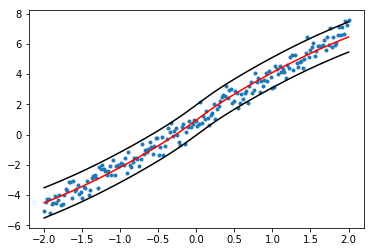

In [15]:
X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var, sample=False)

plt.plot(X, Y, '.')
plt.plot(X, out_mu.data.numpy(), '-r');
plt.plot(X, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');